# Reading Data

In [1]:
# Import libraries
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

from sklearn.linear_model import LogisticRegression
from sklearn. metrics import roc_auc_score, confusion_matrix

In [2]:
# Reading data and adding Destination Airport Clusters
import os
os.chdir("/home/rk9cx/Kaggle/")
cluster_df = pd.read_csv("flights_clean_merged.csv", index_col= False)
flights_df = pd.read_csv("flights_all.csv", index_col=False)
flights_df.drop("ORIGIN_AIRPORT", axis = 1, inplace=True)
flights_df = pd.concat([flights_df, cluster_df["ORIGIN_AIRPORT"]], axis=1)
flights_df.head(10)

,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_AIRPORT
0,4385713,2015,10,1,4,AA,1230,N3DBAA,ABE,5,...,-19,0,0,NaN,NaN,NaN,NaN,NaN,NaN,7
1,4385714,2015,10,1,4,DL,1805,N696DL,ABE,5,...,-10,0,0,NaN,NaN,NaN,NaN,NaN,NaN,7
2,4385715,2015,10,1,4,NK,612,N602NK,ABE,5,...,-14,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2
3,4385716,2015,10,1,4,AA,260,N3GNAA,ABE,10,...,7,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2
4,4385717,2015,10,1,4,AA,1982,N914UY,ABE,10,...,-11,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2
5,4385718,2015,10,1,4,UA,684,N495UA,ABE,14,...,-33,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2
6,4385719,2015,10,1,4,UA,1171,N68452,ABE,14,...,-13,0,0,NaN,NaN,NaN,NaN,NaN,NaN,7
7,4385720,2015,10,1,4,AA,448,N179UW,ABE,15,...,-5,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2
8,4385721,2015,10,1,4,AA,2406,N859AA,ABE,15,...,-1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,7
9,4385722,2015,10,1,4,DL,1617,N809DN,ABE,20,...,-7,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2


# Preprocessing

In [3]:
#converting response variable to 
delay_cutoff = 15
flights_df["ARRIVAL_DELAY"] = flights_df["ARRIVAL_DELAY"].apply(lambda x: 0 if x<15 else 1)
flights_df = flights_df.reset_index(drop=True)
labels_shuffle = flights_df["ARRIVAL_DELAY"]
labels_shuffle.shape

(5713508,)

In [4]:
#Function for one hot-encoding
def make_onehot_feat_dict(df, feat_key, feat_name):
    # Create features for each day of the week
    feat_vals = df[feat_key].values
    all_vals = np.unique(feat_vals)
    N_vals = len(all_vals)
    N_feat = N_vals - 1

    # Create keys
    keys = [0]*N_feat
    for i in range(N_feat):
        keys[i] = 'f_'+feat_name+'_'+ str(all_vals[i])

    # Create value for each training example in dict
    feat_dict = {}
    for i, k in enumerate(keys):
        this_day = all_vals[i]
        feat_dict[k] = feat_vals == this_day
    return feat_dict

In [5]:
#converting day of week into one-hot
daysfeat_dict = make_onehot_feat_dict(flights_df, 'DAY_OF_WEEK', 'day')

In [6]:
#converting months into one-hot
monthsfeat_dict = make_onehot_feat_dict(flights_df, 'MONTH', 'month')

In [7]:
#converting origin airport into one-hot
apfeat_dict = make_onehot_feat_dict(flights_df, 'ORIGIN_AIRPORT', 'aa')

In [8]:
#converting destination airport into one-hot
deafeat_dict = make_onehot_feat_dict(flights_df, 'DESTINATION_AIRPORT', 'da')

In [9]:
#converting Airlines into one-hot
alfeat_dict = make_onehot_feat_dict(flights_df, 'AIRLINE', 'al')

In [10]:
# Add departure hour as a feature
flights_df['HOUR_DEPARTURE'] = np.floor(flights_df['SCHEDULED_DEPARTURE'].values/100).astype(int)

In [11]:
#converting hours departure into one-hot
hrfeat_dict = make_onehot_feat_dict(flights_df, 'HOUR_DEPARTURE', 'hr')

In [12]:
all_dicts = [ daysfeat_dict,deafeat_dict, monthsfeat_dict, alfeat_dict, hrfeat_dict, apfeat_dict]
feat_dict = all_dicts[0].copy()
for d in all_dicts[1:]:
    feat_dict.update(d)

In [13]:
df_feat = pd.DataFrame.from_dict(feat_dict)
df_feat = pd.concat([df_feat, flights_df["SCHEDULED_TIME"], flights_df["DISTANCE"]], axis=1)
df_feat.shape

(5713508, 383)

# Splitting Data into Train and Test

In [14]:
airport_keys = np.array(list(apfeat_dict.keys()))
X_train = {}
X_test = {}
y_train = {}
y_test = {}
for apk in airport_keys:
    # Isolate X and y for each airport
    ap_idx = np.transpose(np.argwhere(apfeat_dict[apk]))[0]
    X_all = df_feat.loc[ap_idx].values
    y_all = labels_shuffle[ap_idx]
    
    # Calculate train and test set size
    N_flights = len(y_all)
    N_train = int(N_flights*.7)
    N_test = N_flights - N_train
    
    # Make train and test sets
    X_train[apk[-3:]] = X_all[:N_train]
    X_test[apk[-3:]] = X_all[N_train:]
    y_train[apk[-3:]] = y_all[:N_train]
    y_test[apk[-3:]] = y_all[N_train:]

# Model 1 - Logistic Regression

In [15]:
%%time
train_aucs = {}
test_aucs = {}
train_ps = {}
test_ps = {}
C = 100000
for k in X_train.keys():
    print(k)
    models = LogisticRegression(C=1)
    models.fit(X_train[k], y_train[k])
    
    # Get probabilities
    train_ps[k] = models.predict_proba(X_train[k])[:,1]
    test_ps[k] = models.predict_proba(X_test[k])[:,1]

    # Evaluate model
    train_aucs[k] = roc_auc_score(y_train[k], train_ps[k])
    test_aucs[k] = roc_auc_score(y_test[k], test_ps[k])

a_1
a_2
a_3
a_4
a_5
a_6
a_7
CPU times: user 1min 53s, sys: 6.23 s, total: 1min 59s
Wall time: 2min


AUC, validation set: 0.6093802628657542
AUC, training set: 0.6515155612012107
0.6093802628657542


(0, 1)

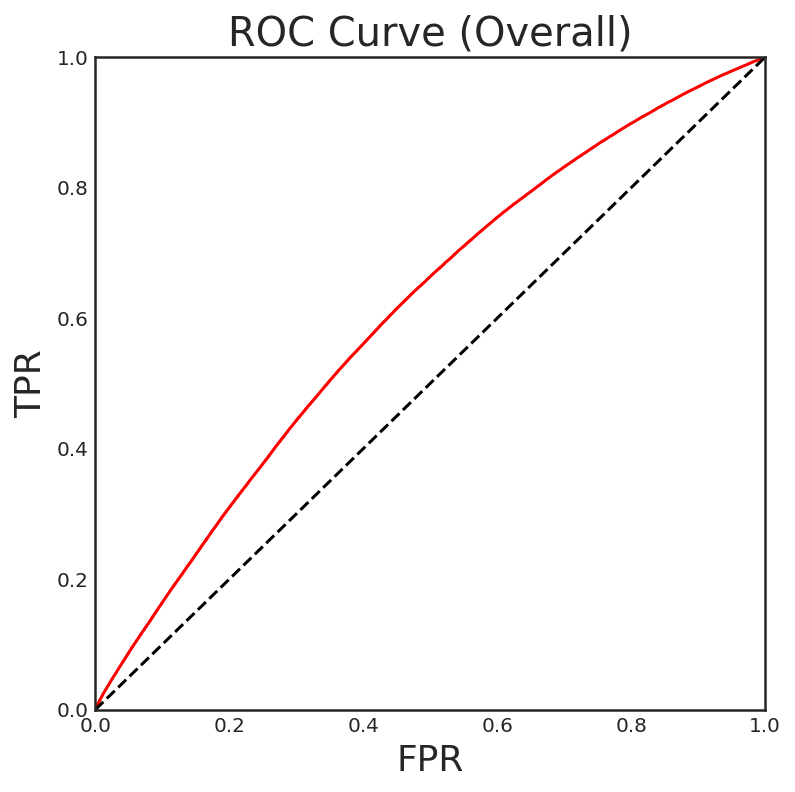

In [16]:
#AUC Calculations
all_ps = np.hstack(list(test_ps.values()))
all_ys = np.hstack(list(y_test.values()))
print('AUC, validation set:', roc_auc_score(all_ys, all_ps))

all_ps_train = np.hstack(list(train_ps.values()))
all_ys_train = np.hstack(list(y_train.values()))
print('AUC, training set:', roc_auc_score(all_ys_train, all_ps_train))


from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_ps)
print(roc_auc_score(all_ys, all_ps))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve (Overall)', fontsize=20)
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.xlim((0,1))
plt.ylim((0,1))

Text(0.5,1,'Prediction accuracy across airports')

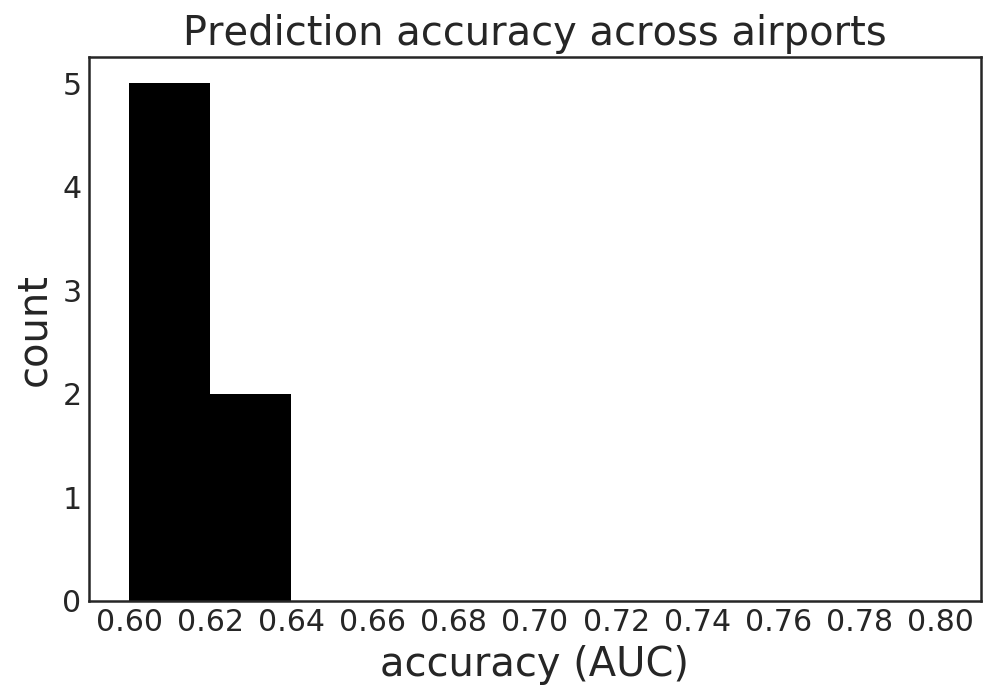

In [17]:
# Plot accuracy
plt.figure(figsize=(8,5))
accs = plt.hist(list(test_aucs.values()),bins=np.arange(0.6,0.8,0.02),color='k')
plt.xlabel('accuracy (AUC)',size=20)
plt.ylabel('count',size=20)
plt.xticks(np.arange(0.6,0.8,0.02), size=15)
plt.yticks(size=15)
plt.title('Prediction accuracy across airports',size=20)

Confusion matrix:
 [[1116439  141868]
 [ 205425   46208]]
Precision:  0.24568791339671198
Recall:  0.18363251242881498
False Negaitve Rate:  0.15540554852844166
Accuracy:  0.769995496509795
0.5354436857685624


(0, 1)

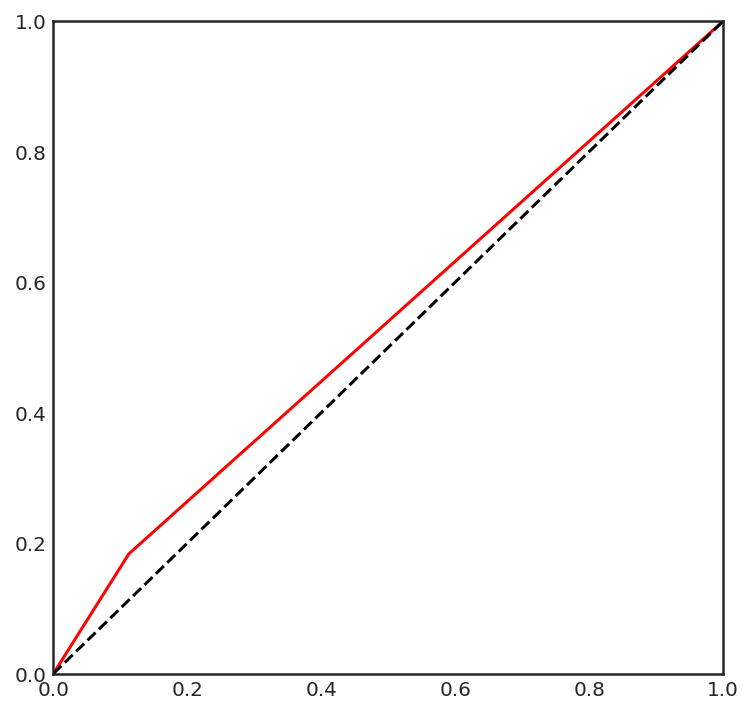

In [19]:
decision_thresh = .3
all_preds = all_ps > decision_thresh
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('False Negaitve Rate: ', all_confuse[1,0]/(all_confuse[1,0]+all_confuse[0,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[1257742     565]
 [ 251391     242]]
Precision:  0.29987608426270135
Recall:  0.0009617180576474469
False Negaitve Rate:  0.1665797514201863
Accuracy:  0.8331350914605878
0.5002563510192523


(0, 1)

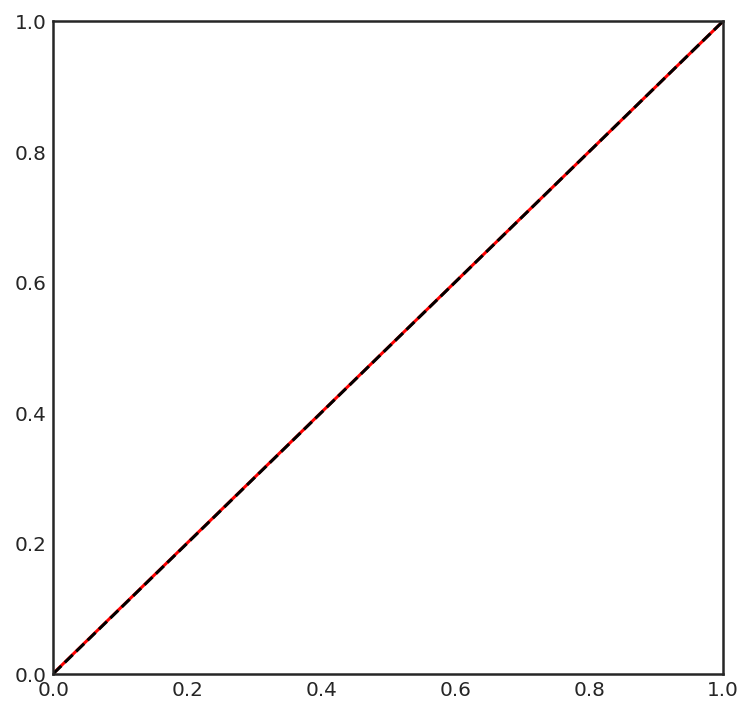

In [18]:
decision_thresh = .5
all_preds = all_ps > decision_thresh
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('False Negaitve Rate: ', all_confuse[1,0]/(all_confuse[1,0]+all_confuse[0,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[1258307       0]
 [ 251633       0]]
Precision:  nan
Recall:  0.0
False Negaitve Rate:  0.16665099275467898
Accuracy:  0.833349007245321


/apps/software/standard/core/anaconda3/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


0.5


(0, 1)

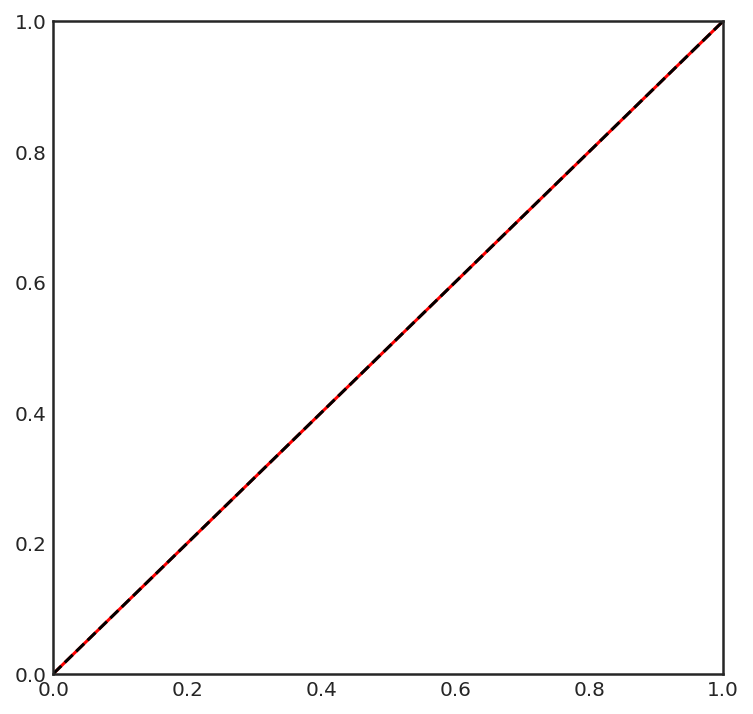

In [20]:
decision_thresh = .7
all_preds = all_ps > decision_thresh
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('False Negaitve Rate: ', all_confuse[1,0]/(all_confuse[1,0]+all_confuse[0,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

# Model 2 - Random Forest

In [21]:
%%time
from sklearn.ensemble import RandomForestClassifier
train_aucs = {}
test_aucs = {}
train_ps = {}
test_ps = {}
for k in X_train.keys():
    print(k)
    models = RandomForestClassifier(n_estimators=300, random_state=0)  
    models.fit(X_train[k], y_train[k])
    
    # Get probabilities
    train_ps[k] = models.predict_proba(X_train[k])[:,1]
    test_ps[k] = models.predict_proba(X_test[k])[:,1]

    # Evaluate model
    train_aucs[k] = roc_auc_score(y_train[k], train_ps[k])
    test_aucs[k] = roc_auc_score(y_test[k], test_ps[k])

a_1
a_2
a_3
a_4
a_5
a_6
a_7
CPU times: user 1h 25min 2s, sys: 35.5 s, total: 1h 25min 38s
Wall time: 1h 25min 41s


AUC, validation set: 0.5974718238253878
AUC, training set: 0.992764912203526
0.5974718238253878


(0, 1)

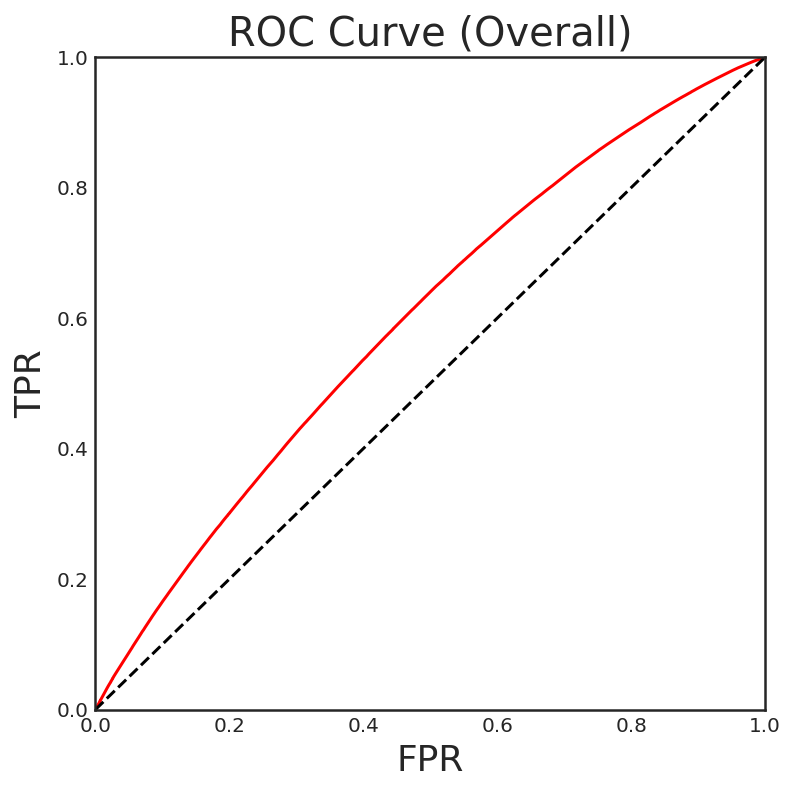

In [22]:
#AUC Calculations
all_ps = np.hstack(list(test_ps.values()))
all_ys = np.hstack(list(y_test.values()))
print('AUC, validation set:', roc_auc_score(all_ys, all_ps))

all_ps_train = np.hstack(list(train_ps.values()))
all_ys_train = np.hstack(list(y_train.values()))
print('AUC, training set:', roc_auc_score(all_ys_train, all_ps_train))


from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_ps)
print(roc_auc_score(all_ys, all_ps))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve (Overall)', fontsize=20)
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.xlim((0,1))
plt.ylim((0,1))

Text(0.5,1,'Prediction accuracy across airports')

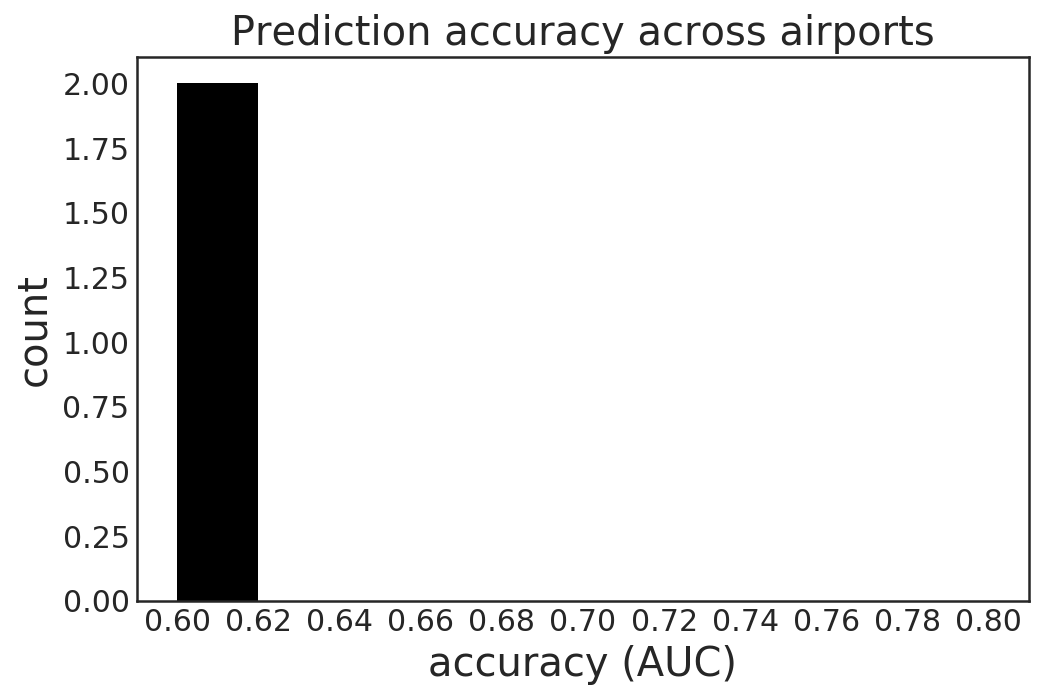

In [23]:
# Plot accuracy
plt.figure(figsize=(8,5))
accs = plt.hist(list(test_aucs.values()),bins=np.arange(0.6,0.8,0.02),color='k')
plt.xlabel('accuracy (AUC)',size=20)
plt.ylabel('count',size=20)
plt.xticks(np.arange(0.6,0.8,0.02), size=15)
plt.yticks(size=15)
plt.title('Prediction accuracy across airports',size=20)

Confusion matrix:
 [[1033597  224710]
 [ 182702   68931]]
Precision:  0.23474582909062428
False Negaitve Rate:  0.15021142005378613
Recall:  0.2739346588086618
Accuracy:  0.7301800071526021
0.5476767190842738


(0, 1)

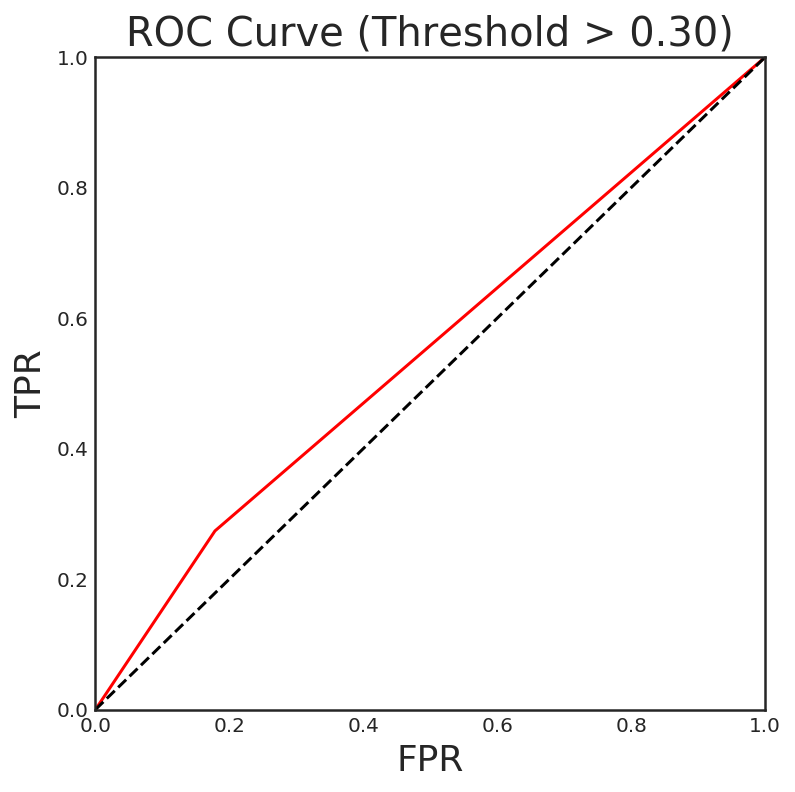

In [24]:
decision_thresh = .3
all_preds = all_ps > decision_thresh
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('False Negaitve Rate: ', all_confuse[1,0]/(all_confuse[1,0]+all_confuse[0,0]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve (Threshold > 0.30)', fontsize=20)
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[1233625   24682]
 [ 242354    9279]]
Precision:  0.27322517004799624
Recall:  0.03687513164012669
False Negaitve Rate:  0.16419881312674503
Accuracy:  0.8231479396532313
0.5086299433559112


(0, 1)

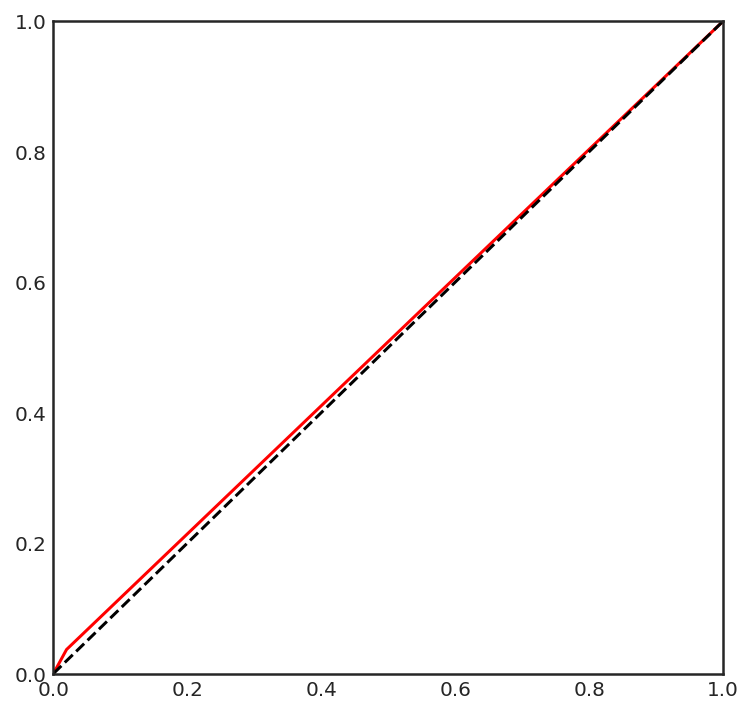

In [25]:
decision_thresh = .5
all_preds = all_ps > decision_thresh
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('False Negaitve Rate: ', all_confuse[1,0]/(all_confuse[1,0]+all_confuse[0,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[1255076    3231]
 [ 250461    1172]]
Precision:  0.2661821485350897
Recall:  0.004657576708937222
False Negaitve Rate:  0.16635991011844942
Accuracy:  0.8319853769023935
0.5010449204271663


(0, 1)

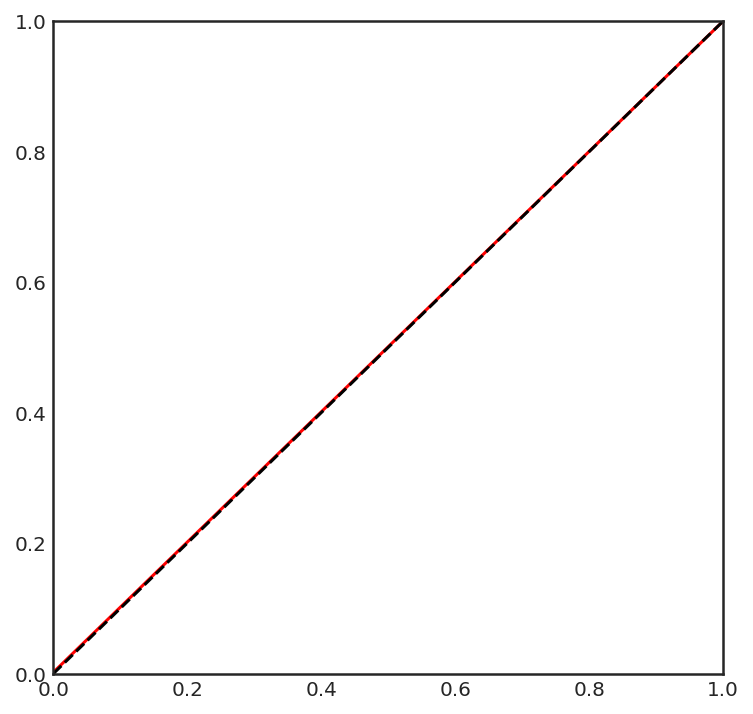

In [26]:
decision_thresh = .7
all_preds = all_ps > decision_thresh
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('False Negaitve Rate: ', all_confuse[1,0]/(all_confuse[1,0]+all_confuse[0,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

# Model 3 - Gradient Boosted Trees

In [34]:
%%time
from sklearn.ensemble import RandomForestClassifier
train_aucs = {}
test_aucs = {}
train_ps = {}
test_ps = {}
for k in X_train.keys():
    print(k)
    models = RandomForestClassifier(n_estimators=300, random_state=0)  
    models.fit(X_train[k], y_train[k])
    
    # Get probabilities
    train_ps[k] = models.predict_proba(X_train[k])[:,1]
    test_ps[k] = models.predict_proba(X_test[k])[:,1]

    # Evaluate model
    train_aucs[k] = roc_auc_score(y_train[k], train_ps[k])
    test_aucs[k] = roc_auc_score(y_test[k], test_ps[k])

a_1
a_2
a_3
a_4
a_5
a_6
a_7
CPU times: user 1h 27min 25s, sys: 2.86 s, total: 1h 27min 28s
Wall time: 1h 27min 31s


AUC, validation set: 0.5974718238253878
AUC, training set: 0.992764912203526
0.5974718238253878


(0, 1)

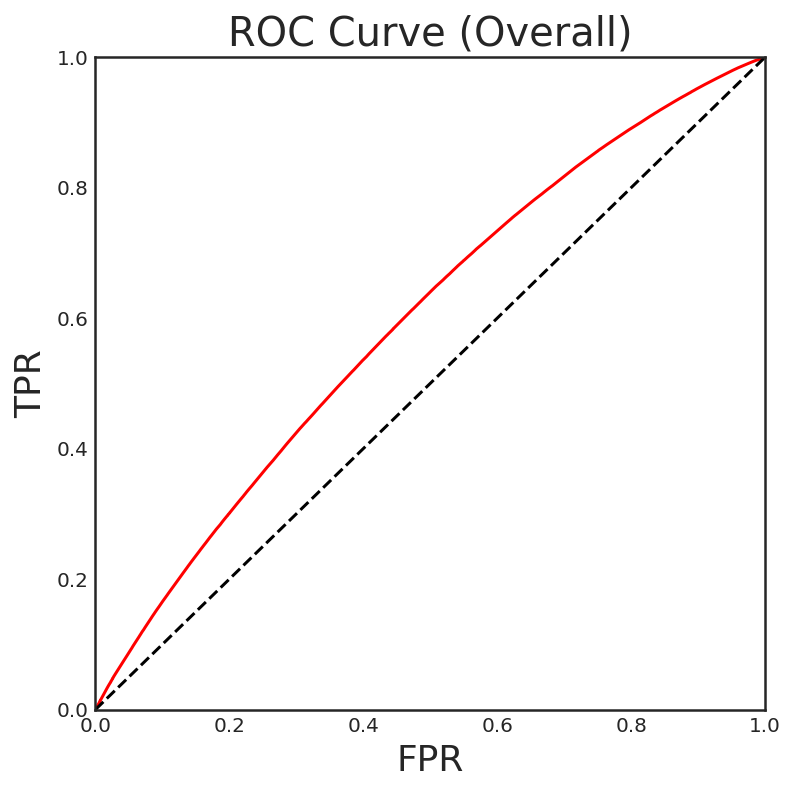

In [35]:
#AUC Calculations
all_ps = np.hstack(list(test_ps.values()))
all_ys = np.hstack(list(y_test.values()))
print('AUC, validation set:', roc_auc_score(all_ys, all_ps))

all_ps_train = np.hstack(list(train_ps.values()))
all_ys_train = np.hstack(list(y_train.values()))
print('AUC, training set:', roc_auc_score(all_ys_train, all_ps_train))


from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_ps)
print(roc_auc_score(all_ys, all_ps))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve (Overall)', fontsize=20)
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.xlim((0,1))
plt.ylim((0,1))

Text(0.5,1,'Prediction accuracy across airports')

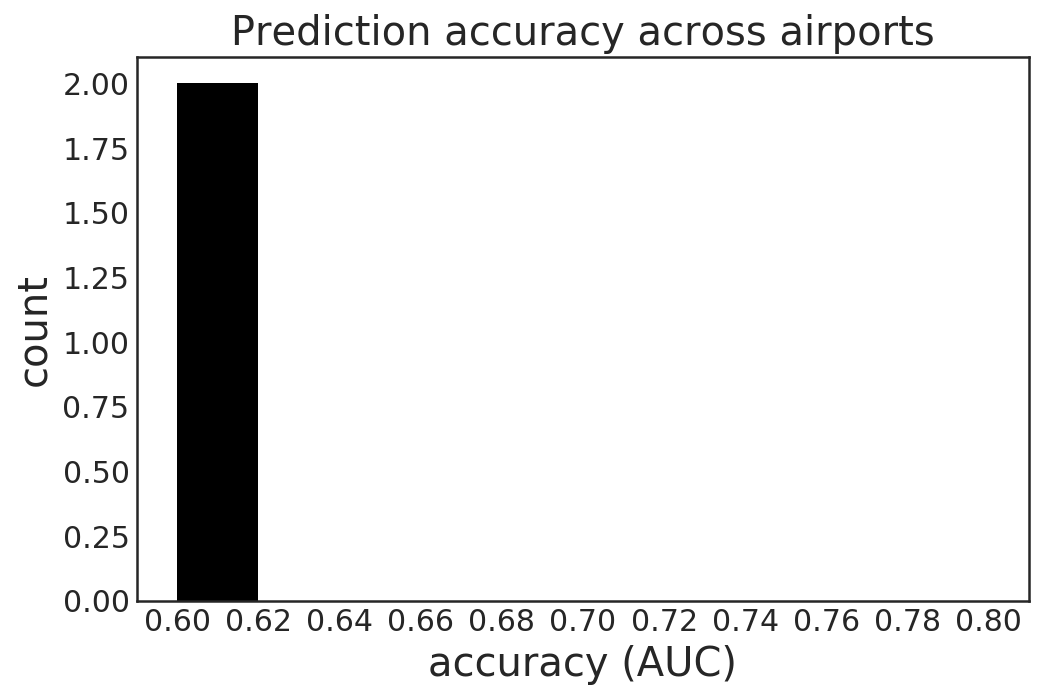

In [36]:
# Plot accuracy
plt.figure(figsize=(8,5))
accs = plt.hist(list(test_aucs.values()),bins=np.arange(0.6,0.8,0.02),color='k')
plt.xlabel('accuracy (AUC)',size=20)
plt.ylabel('count',size=20)
plt.xticks(np.arange(0.6,0.8,0.02), size=15)
plt.yticks(size=15)
plt.title('Prediction accuracy across airports',size=20)

Confusion matrix:
 [[1033597  224710]
 [ 182702   68931]]
Precision:  0.23474582909062428
False Negaitve Rate:  0.15021142005378613
Recall:  0.2739346588086618
Accuracy:  0.7301800071526021
0.5476767190842738


(0, 1)

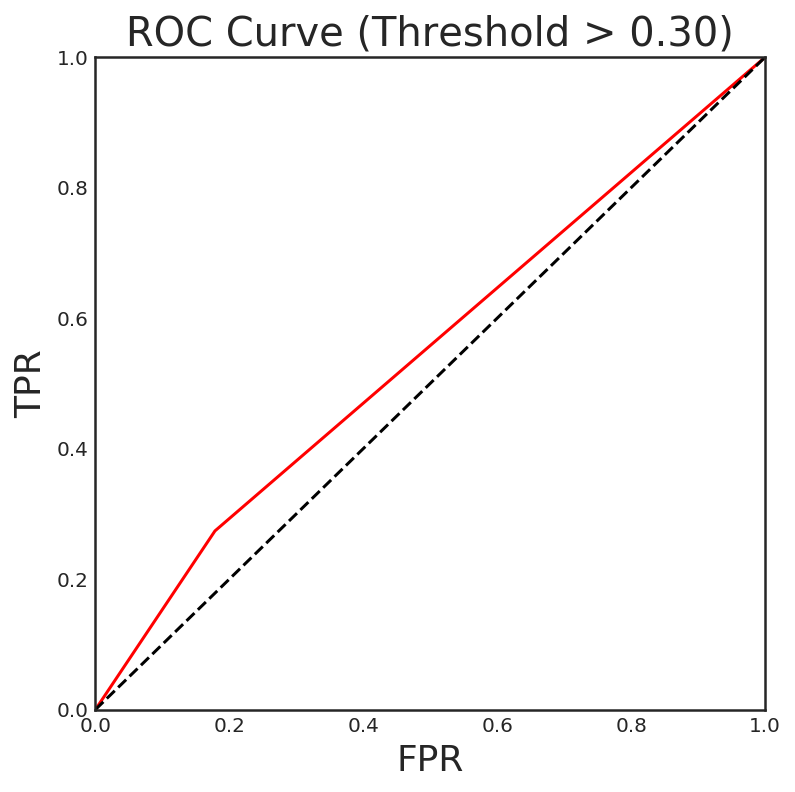

In [37]:
decision_thresh = .3
all_preds = all_ps > decision_thresh
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('False Negaitve Rate: ', all_confuse[1,0]/(all_confuse[1,0]+all_confuse[0,0]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve (Threshold > 0.30)', fontsize=20)
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[1233625   24682]
 [ 242354    9279]]
Precision:  0.27322517004799624
Recall:  0.03687513164012669
False Negaitve Rate:  0.16419881312674503
Accuracy:  0.8231479396532313
0.5086299433559112


(0, 1)

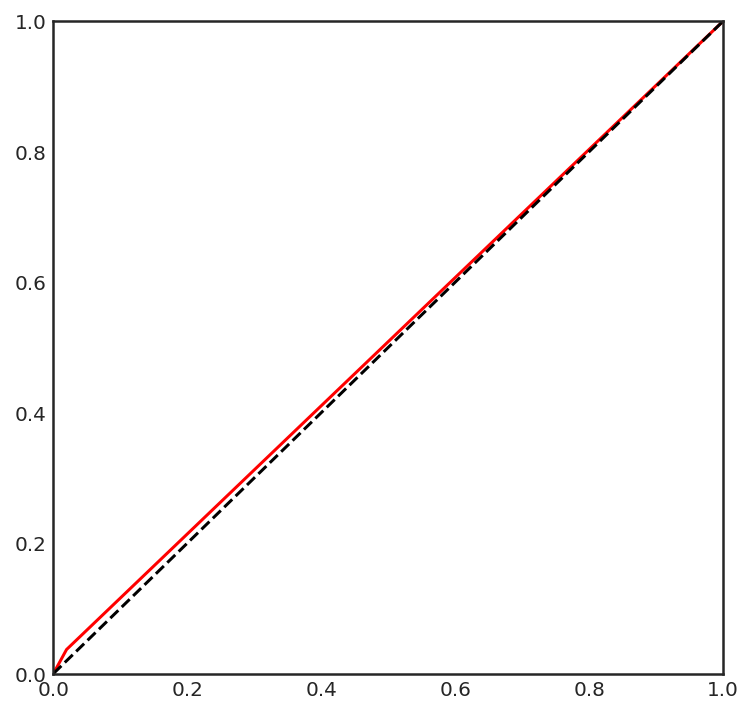

In [38]:
decision_thresh = .5
all_preds = all_ps > decision_thresh
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('False Negaitve Rate: ', all_confuse[1,0]/(all_confuse[1,0]+all_confuse[0,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[1255076    3231]
 [ 250461    1172]]
Precision:  0.2661821485350897
Recall:  0.004657576708937222
False Negaitve Rate:  0.16635991011844942
Accuracy:  0.8319853769023935
0.5010449204271663


(0, 1)

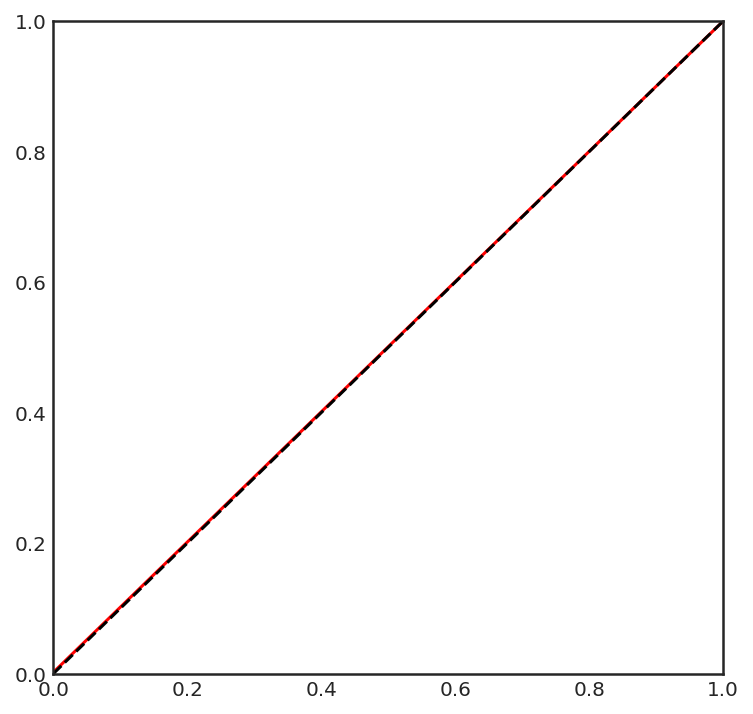

In [39]:
decision_thresh = .7
all_preds = all_ps > decision_thresh
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('False Negaitve Rate: ', all_confuse[1,0]/(all_confuse[1,0]+all_confuse[0,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))